# 📦 Necessary Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

2025-05-21 16:34:02.355018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 16:34:02.355182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 16:34:02.516843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define Necessary Functions 🛠️

In [4]:
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGn):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [5]:
# plot images
def plotImages(images):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title("Training Loss And Accuracy")
    plt.ylabel("Loss/Accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

# 🗄️ Load and Preprocessing Images

In [7]:
# Processing The Image Datasets
classes = ["Chameleon", "Crocodile", "Frog", "Gecko", "Iguana", "Kumodo Dragon", "Salamander", "Snake", "Tuatara", "Turtle"]

train_path = '/kaggle/input/reptiles-and-amphibians-dataset/train'
valid_path = '/kaggle/input/reptiles-and-amphibians-dataset/valid'
test_path = '/kaggle/input/reptiles-and-amphibians-dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=classes, batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=classes, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=classes, batch_size=10, shuffle=False)

Found 17501 images belonging to 10 classes.
Found 998 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


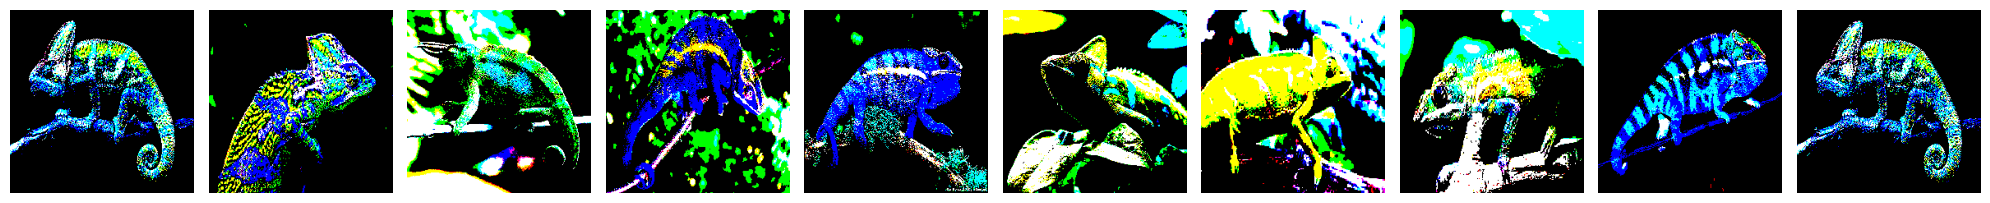

In [8]:
imgs, label = next(test_batches)
plotImages(imgs)

# 🔬Transfer Learning and Fine-Tuning with ResNet101

## ⚒️Build Model

In [9]:
base_model = tf.keras.applications.ResNet101(weights='imagenet')
# base_model.trainable = False

179648224/179648224 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## ⚙️ Model Fine-Tuning

In [10]:
x = base_model.layers[-3].output
x = GlobalAveragePooling2D()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units=10, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = output)

In [11]:
#freezing
for layer in model.layers[:-20]:
    layer.trainable = False

## 🧰 Define Callback

In [12]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/Reptiles_and_Amphibians_ResNet101_Tuned_Model.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# 🏋️‍♀️ Train Model

In [13]:
optimizer = tf.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, weight_decay=0.01/40)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
H = model.fit(x=train_batches, validation_data=valid_batches, callbacks=[model_checkpoint_callback], epochs=5)
plot_hist(H)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8787 - loss: 0.4004
Epoch 1: val_accuracy improved from 0.91483 to 0.92184, saving model to /kaggle/working/Reptiles_and_Amphibians_ResNet101_Tuned_Model.weights.h5
547/547 ━━━━━━━━━━━━━━━━━━━━ 123s 220ms/step - accuracy: 0.8787 - loss: 0.4004 - val_accuracy: 0.9218 - val_loss: 0.2870
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8939 - loss: 0.3520
Epoch 2: val_accuracy did not improve from 0.92184
547/547 ━━━━━━━━━━━━━━━━━━━━ 130s 235ms/step - accuracy: 0.8939 - loss: 0.3520 - val_accuracy: 0.9218 - val_loss: 0.2689
Epoch 3/5
316/547 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.9036 - loss: 0.3337

# 🔮 Evaluate Model

In [ ]:
test_labels = test_batches.classes

In [42]:
predict = model.predict(x=test_batches, verbose=0)

In [43]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predict, axis=-1))

In [18]:
test_batches.class_indices

{'Chameleon': 0,
 'Crocodile': 1,
 'Frog': 2,
 'Gecko': 3,
 'Iguana': 4,
 'Kumodo Dragon': 5,
 'Salamander': 6,
 'Snake': 7,
 'Tuatara': 8,
 'Turtle': 9}

## 📉 Confusion Matrix

Confusion matrix, without normalization


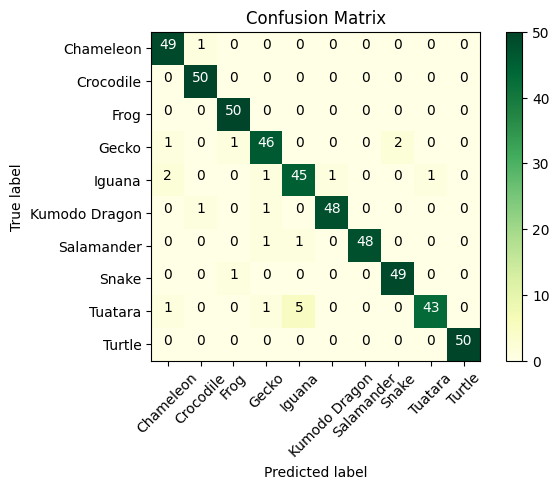

In [44]:
cm_plot_labels = ["Chameleon", "Crocodile", "Frog", "Gecko", "Iguana", "Kumodo Dragon", "Salamander", "Snake", "Tuatara", "Turtle"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# 💾 Save Model

In [20]:
model.save("Reptiles_and_Amphibians_ResNet101_Tuned_Model.h5")

In [46]:
from IPython.display import FileLink
FileLink(r'Reptiles_and_Amphibians_ResNet101_Tuned_Model.h5')

/kaggle/working/Reptiles_and_Amphibians_ResNet101_Tuned_Model.weights.h5